<a href="https://colab.research.google.com/github/shumshersubashgautam/Quantum-MNIST-Classification/blob/main/Noise.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from IPython.display import clear_output


In [2]:
!pip install tensorflow==2.7.0
clear_output()

In [3]:
!pip install tensorflow-quantum==0.7.2
clear_output()

In [39]:
!pip install -q git+https://github.com/tensorflow/docs
clear_output()

In [40]:
# Update package resources to account for version changes.
import importlib, pkg_resources
importlib.reload(pkg_resources)

<module 'pkg_resources' from '/usr/local/lib/python3.8/dist-packages/pkg_resources/__init__.py'>

In [41]:
import random
import cirq
import sympy
import tensorflow_quantum as tfq
import tensorflow as tf
import numpy as np
# Plotting
import matplotlib.pyplot as plt
import tensorflow_docs as tfdocs
import tensorflow_docs.plots

In [42]:
def x_circuit(qubits):
  """Produces an X wall circuit on `qubits`."""
  return cirq.Circuit(cirq.X.on_each(*qubits))

def make_noisy(circuit, p):
  """Add a depolarization channel to all qubits in `circuit` before measurement."""
  return circuit + cirq.Circuit(cirq.depolarize(p).on_each(*circuit.all_qubits()))

my_qubits = cirq.GridQubit.rect(1, 2)
my_circuit = x_circuit(my_qubits)
my_noisy_circuit = make_noisy(my_circuit, 0.5)
my_circuit

(0, 0): ───X───

(0, 1): ───X───

In [43]:
my_noisy_circuit

(0, 0): ───X───D(0.5)───

(0, 1): ───X───D(0.5)───

In [44]:
rho = cirq.final_density_matrix(my_circuit)
np.round(rho, 3)

array([[0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j],
       [0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j],
       [0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j],
       [0.+0.j, 0.+0.j, 0.+0.j, 1.+0.j]], dtype=complex64)

In [45]:
rho = cirq.final_density_matrix(my_noisy_circuit)
np.round(rho, 3)

array([[0.111+0.j, 0.   +0.j, 0.   +0.j, 0.   +0.j],
       [0.   +0.j, 0.222+0.j, 0.   +0.j, 0.   +0.j],
       [0.   +0.j, 0.   +0.j, 0.222+0.j, 0.   +0.j],
       [0.   +0.j, 0.   +0.j, 0.   +0.j, 0.444+0.j]], dtype=complex64)

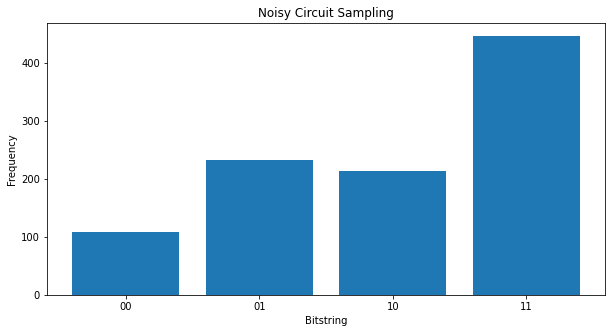

In [46]:
"""Sample from my_noisy_circuit."""
def plot_samples(circuit):
  samples = cirq.sample(circuit + cirq.measure(*circuit.all_qubits(), key='bits'), repetitions=1000)
  freqs, _ = np.histogram(samples.data['bits'], bins=[i+0.01 for i in range(-1,2** len(my_qubits))])
  plt.figure(figsize=(10,5))
  plt.title('Noisy Circuit Sampling')
  plt.xlabel('Bitstring')
  plt.ylabel('Frequency')
  plt.bar([i for i in range(2** len(my_qubits))], freqs, tick_label=['00','01','10','11'])

plot_samples(my_noisy_circuit)

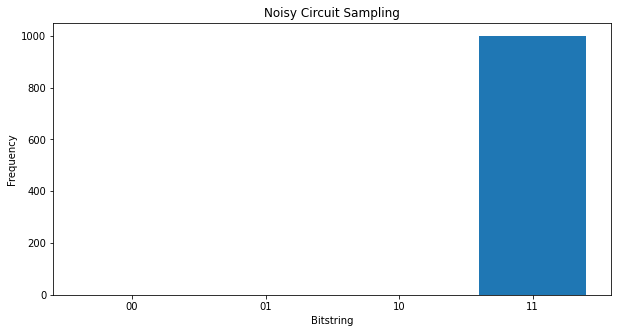

In [47]:
"""Sample from my_circuit."""
plot_samples(my_circuit)

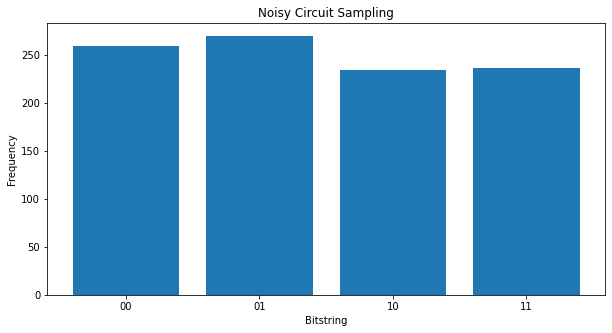

In [48]:
my_really_noisy_circuit = make_noisy(my_circuit, 0.75)
plot_samples(my_really_noisy_circuit)

In [49]:
"""Draw bitstring samples from `my_noisy_circuit`"""
bitstrings = tfq.layers.Sample(backend='noisy')(my_noisy_circuit, repetitions=1000)

<BarContainer object of 4 artists>

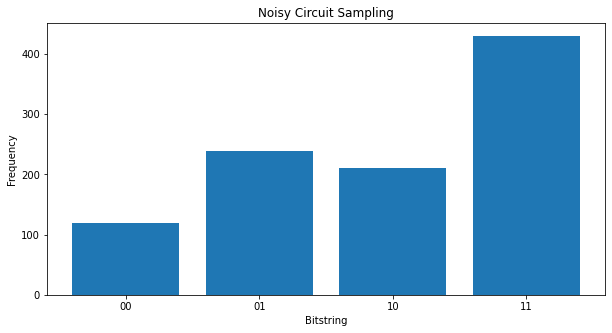

In [50]:
numeric_values = np.einsum('ijk,k->ij', bitstrings.to_tensor().numpy(), [1, 2])[0]
freqs, _ = np.histogram(numeric_values, bins=[i+0.01 for i in range(-1,2** len(my_qubits))])
plt.figure(figsize=(10,5))
plt.title('Noisy Circuit Sampling')
plt.xlabel('Bitstring')
plt.ylabel('Frequency')
plt.bar([i for i in range(2** len(my_qubits))], freqs, tick_label=['00','01','10','11'])

In [51]:
some_observables = [cirq.X(my_qubits[0]), cirq.Z(my_qubits[0]), 3.0 * cirq.Y(my_qubits[1]) + 1]
some_observables

[cirq.X(cirq.GridQubit(0, 0)),
 cirq.Z(cirq.GridQubit(0, 0)),
 cirq.PauliSum(cirq.LinearDict({frozenset({(cirq.GridQubit(0, 1), cirq.Y)}): (3+0j), frozenset(): (1+0j)}))]

In [52]:
noiseless_sampled_expectation = tfq.layers.SampledExpectation(backend='noiseless')(
    my_circuit, operators=some_observables, repetitions=10000
)
noiseless_sampled_expectation.numpy()

array([[-1.00e-03, -1.00e+00,  1.03e+00]], dtype=float32)

In [53]:
noisy_sampled_expectation = tfq.layers.SampledExpectation(backend='noisy')(
    [my_noisy_circuit, my_really_noisy_circuit], operators=some_observables, repetitions=10000
)
noisy_sampled_expectation.numpy()

array([[ 0.0052    , -0.3338    ,  0.99880004],
       [-0.008     ,  0.0126    ,  0.97      ]], dtype=float32)

In [54]:
noiseless_analytic_expectation = tfq.layers.Expectation(backend='noiseless')(
    my_circuit, operators=some_observables
)
noiseless_analytic_expectation.numpy()

array([[ 1.9106853e-15, -1.0000000e+00,  1.0000002e+00]], dtype=float32)

In [55]:
qubits = cirq.GridQubit.rect(1, 8)
circuits, labels, pauli_sums, _ = tfq.datasets.xxz_chain(qubits, 'closed')
circuits[0]

184459264/184449737 [==============================] - 1s 0us/step


┌──────────────────┐   ┌──────────────────────┐   ┌──────────────────────┐                                       ┌──────────────────┐   ┌──────────────────┐   ┌──────────────────┐                                        ┌──────────────────┐   ┌──────────────────┐   ┌──────────────────┐                                        ┌──────────────────┐   ┌──────────────────┐   ┌──────────────────┐
(0, 0): ───X───H───@─────────────ZZ───────────────────────YY─────────────────────────XX─────────────ZZ──────────YY──────────XX────────────────────ZZ─────────────────────YY─────────────────────XX───────────ZZ─────────YY───────────XX─────────────────────ZZ─────────────────────YY─────────────────────XX───────────ZZ─────────YY───────────XX─────────────────────ZZ─────────────────────YY─────────────────────XX───────────ZZ──────────YY──────────XX──────────
                   │             │                        │                          │              │           │           │                     │                      │                      │            │          │            │                      │                      │                      │            │          │            │                      │                      │                      │            │           │           │
(0, 1): ───X───────X────ZZ───────┼─────────────YY─────────┼───────────────XX─────────┼──────────────ZZ^-0.941───YY^-0.767───XX^-0.767────ZZ───────┼─────────────YY───────┼─────────────XX───────┼────────────ZZ^-0.98───YY^(-9/11)───XX^(-9/11)────ZZ───────┼─────────────YY───────┼─────────────XX───────┼────────────ZZ^-0.98───YY^(-9/11)───XX^(-9/11)────ZZ───────┼─────────────YY───────┼─────────────XX───────┼────────────ZZ^-0.985───YY^-0.901───XX^-0.901───
                        │        │             │          │               │          │                                                   │        │             │        │             │        │                                                  │        │             │        │             │        │                                                  │        │             │        │             │        │
(0, 2): ───X───H───@────ZZ^-0.977┼─────────────YY^(-10/11)┼───────────────XX^(-10/11)┼──────────────ZZ──────────YY──────────XX───────────ZZ^-0.968┼─────────────YY^-0.898┼─────────────XX^-0.898┼────────────ZZ─────────YY───────────XX────────────ZZ^-0.962┼─────────────YY^-0.869┼─────────────XX^-0.869┼────────────ZZ─────────YY───────────XX────────────ZZ^-0.954┼─────────────YY^-0.904┼─────────────XX^-0.904┼────────────ZZ──────────YY──────────XX──────────
                   │             │                        │                          │              │           │           │                     │                      │                      │            │          │            │                      │                      │                      │            │          │            │                      │                      │                      │            │           │           │
(0, 3): ───X───────X────ZZ───────┼─────────────YY─────────┼───────────────XX─────────┼──────────────ZZ^-0.941───YY^-0.767───XX^-0.767────ZZ───────┼─────────────YY───────┼─────────────XX───────┼────────────ZZ^-0.98───YY^(-9/11)───XX^(-9/11)────ZZ───────┼─────────────YY───────┼─────────────XX───────┼────────────ZZ^-0.98───YY^(-9/11)───XX^(-9/11)────ZZ───────┼─────────────YY───────┼─────────────XX───────┼────────────ZZ^-0.985───YY^-0.901───XX^-0.901───
                        │        │             │          │               │          │                                                   │        │             │        │             │        │                                                  │        │             │        │             │        │                                                  │        │             │        │             │        │
(0, 4): ───X───H───@────ZZ^-0.977┼─────────────YY^(-10/11)┼───────────────XX^(-10/11)┼────────

In [56]:
def get_data(qubits, depolarize_p=0.):
  """Return quantum data circuits and labels in `tf.Tensor` form."""
  circuits, labels, pauli_sums, _ = tfq.datasets.xxz_chain(qubits, 'closed')
  if depolarize_p >= 1e-5:
    circuits = [circuit.with_noise(cirq.depolarize(depolarize_p)) for circuit in circuits]
  tmp = list(zip(circuits, labels))
  random.shuffle(tmp)
  circuits_tensor = tfq.convert_to_tensor([x[0] for x in tmp])
  labels_tensor = tf.convert_to_tensor([x[1] for x in tmp])

  return circuits_tensor, labels_tensor

In [57]:
def modelling_circuit(qubits, depth, depolarize_p=0.):
  """A simple classifier circuit."""
  dim = len(qubits)
  ret = cirq.Circuit(cirq.H.on_each(*qubits))

  for i in range(depth):
    # Entangle layer.
    ret += cirq.Circuit(cirq.CX(q1, q2) for (q1, q2) in zip(qubits[::2], qubits[1::2]))
    ret += cirq.Circuit(cirq.CX(q1, q2) for (q1, q2) in zip(qubits[1::2], qubits[2::2]))
    # Learnable rotation layer.
    # i_params = sympy.symbols(f'layer-{i}-0:{dim}')
    param = sympy.Symbol(f'layer-{i}')
    single_qb = cirq.X
    if i % 2 == 1:
      single_qb = cirq.Y
    ret += cirq.Circuit(single_qb(q) ** param for q in qubits)

  if depolarize_p >= 1e-5:
    ret = ret.with_noise(cirq.depolarize(depolarize_p))

  return ret, [op(q) for q in qubits for op in [cirq.X, cirq.Y, cirq.Z]]

modelling_circuit(qubits, 3)[0]

(0, 0): ───H───@───────X^(layer-0)───@───────Y^(layer-1)───@───────X^(layer-2)───
               │                     │                     │
(0, 1): ───H───X───@───X^(layer-0)───X───@───Y^(layer-1)───X───@───X^(layer-2)───
                   │                     │                     │
(0, 2): ───H───@───X───X^(layer-0)───@───X───Y^(layer-1)───@───X───X^(layer-2)───
               │                     │                     │
(0, 3): ───H───X───@───X^(layer-0)───X───@───Y^(layer-1)───X───@───X^(layer-2)───
                   │                     │                     │
(0, 4): ───H───@───X───X^(layer-0)───@───X───Y^(layer-1)───@───X───X^(layer-2)───
               │                     │                     │
(0, 5): ───H───X───@───X^(layer-0)───X───@───Y^(layer-1)───X───@───X^(layer-2)───
                   │                     │                     │
(0, 6): ───H───@───X───X^(layer-0)───@───X───Y^(layer-1)───@───X───X^(layer-2)───
               │                     │                     │
(0, 7): ───H───X───────X^(layer-0)───X───────Y^(layer-1)───X───────X^(layer-2)───

In [58]:
def build_keras_model(qubits, depolarize_p=0.):
  """Prepare a noisy hybrid quantum classical Keras model."""
  spin_input = tf.keras.Input(shape=(), dtype=tf.dtypes.string)

  circuit_and_readout = modelling_circuit(qubits, 4, depolarize_p)
  if depolarize_p >= 1e-5:
    quantum_model = tfq.layers.NoisyPQC(*circuit_and_readout, sample_based=False, repetitions=10)(spin_input)
  else:
    quantum_model = tfq.layers.PQC(*circuit_and_readout)(spin_input)

  intermediate = tf.keras.layers.Dense(4, activation='sigmoid')(quantum_model)
  post_process = tf.keras.layers.Dense(1)(intermediate)

  return tf.keras.Model(inputs=[spin_input], outputs=[post_process])

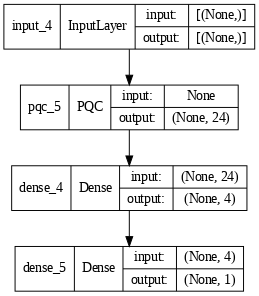

In [59]:
training_histories = dict()
depolarize_p = 0.
n_epochs = 50
phase_classifier = build_keras_model(qubits, depolarize_p)

phase_classifier.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.02),
                   loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
                   metrics=['accuracy'])


# Show the keras plot of the model
tf.keras.utils.plot_model(phase_classifier, show_shapes=True, dpi=70)

In [60]:
noiseless_data, noiseless_labels = get_data(qubits, depolarize_p)
training_histories['noiseless'] = phase_classifier.fit(x=noiseless_data,
                         y=noiseless_labels,
                         batch_size=16,
                         epochs=n_epochs,
                         validation_split=0.15,
                         verbose=1)

Epoch 1/50
4/4 [==============================] - 2s 257ms/step - loss: 0.7100 - accuracy: 0.5469 - val_loss: 0.7350 - val_accuracy: 0.5833
Epoch 2/50
4/4 [==============================] - 1s 156ms/step - loss: 0.6824 - accuracy: 0.4531 - val_loss: 0.7107 - val_accuracy: 0.5833
Epoch 3/50
4/4 [==============================] - 1s 148ms/step - loss: 0.6740 - accuracy: 0.4531 - val_loss: 0.6913 - val_accuracy: 0.5833
Epoch 4/50
4/4 [==============================] - 1s 148ms/step - loss: 0.6641 - accuracy: 0.4531 - val_loss: 0.6841 - val_accuracy: 0.5833
Epoch 5/50
4/4 [==============================] - 1s 156ms/step - loss: 0.6549 - accuracy: 0.4531 - val_loss: 0.6840 - val_accuracy: 0.5833
Epoch 6/50
4/4 [==============================] - 1s 155ms/step - loss: 0.6468 - accuracy: 0.4531 - val_loss: 0.6852 - val_accuracy: 0.5833
Epoch 7/50
4/4 [==============================] - 1s 140ms/step - loss: 0.6389 - accuracy: 0.5156 - val_loss: 0.6826 - val_accuracy: 0.5833
Epoch 8/50
4/4 [====

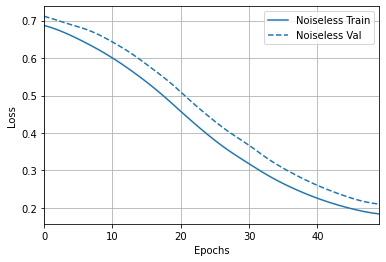

In [61]:
loss_plotter = tfdocs.plots.HistoryPlotter(metric = 'loss', smoothing_std=10)
loss_plotter.plot(training_histories)

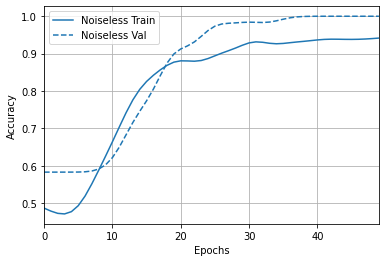

In [62]:
acc_plotter = tfdocs.plots.HistoryPlotter(metric = 'accuracy', smoothing_std=10)
acc_plotter.plot(training_histories)

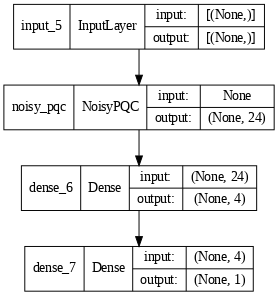

In [63]:
depolarize_p = 0.001
n_epochs = 50
noisy_phase_classifier = build_keras_model(qubits, depolarize_p)

noisy_phase_classifier.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.02),
                   loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
                   metrics=['accuracy'])


# Show the keras plot of the model
tf.keras.utils.plot_model(noisy_phase_classifier, show_shapes=True, dpi=70)

In [64]:
noisy_data, noisy_labels = get_data(qubits, depolarize_p)
training_histories['noisy'] = noisy_phase_classifier.fit(x=noisy_data,
                         y=noisy_labels,
                         batch_size=16,
                         epochs=n_epochs,
                         validation_split=0.15,
                         verbose=1)

Epoch 1/50
4/4 [==============================] - 51s 11s/step - loss: 0.7007 - accuracy: 0.5000 - val_loss: 0.6818 - val_accuracy: 0.3333
Epoch 2/50
4/4 [==============================] - 38s 10s/step - loss: 0.6973 - accuracy: 0.5000 - val_loss: 0.7070 - val_accuracy: 0.3333
Epoch 3/50
4/4 [==============================] - 41s 10s/step - loss: 0.6924 - accuracy: 0.5000 - val_loss: 0.7000 - val_accuracy: 0.3333
Epoch 4/50
4/4 [==============================] - 40s 11s/step - loss: 0.6903 - accuracy: 0.5000 - val_loss: 0.6931 - val_accuracy: 0.3333
Epoch 5/50
4/4 [==============================] - 41s 11s/step - loss: 0.6904 - accuracy: 0.5000 - val_loss: 0.6945 - val_accuracy: 0.3333
Epoch 6/50
4/4 [==============================] - 37s 9s/step - loss: 0.6859 - accuracy: 0.5000 - val_loss: 0.6826 - val_accuracy: 0.3333
Epoch 7/50
4/4 [==============================] - 39s 9s/step - loss: 0.6824 - accuracy: 0.5000 - val_loss: 0.6766 - val_accuracy: 0.3333
Epoch 8/50
4/4 [=============

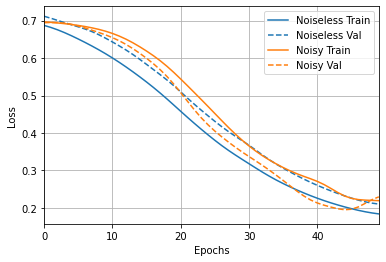

In [65]:
loss_plotter.plot(training_histories)

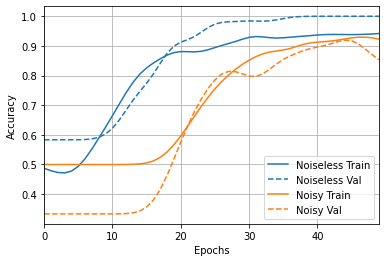

In [66]:
acc_plotter.plot(training_histories)